In [1]:
import string

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('/content/drive/MyDrive/MachineLearningClass/names-gen-data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Polish', 'Irish', 'Russian', 'Korean', 'Chinese', 'Italian', 'Portuguese', 'Spanish', 'French', 'Czech', 'Greek', 'Scottish', 'Arabic', 'Japanese', 'German', 'Dutch', 'English', 'Vietnamese']
O'Neal


In [4]:
import torch
import torch.nn as nn
import math

class TransformerNameGen(nn.Module):
    def __init__(self, vocab_size, num_categories, emb_size=128, nhead=2, num_decoder_layers=1, dim_feedforward=512, dropout=0.1):
        super(TransformerNameGen, self).__init__()
        self.char_embedding = nn.Embedding(vocab_size, emb_size)
        self.cat_embedding = nn.Embedding(num_categories, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout)
        self.emb_size = emb_size
        self.vocab_size = vocab_size

        self.transformer_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead,
                                       dim_feedforward=dim_feedforward, dropout=dropout)
            for _ in range(num_decoder_layers)
        ])
        self.fc_out = nn.Linear(emb_size, vocab_size)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, category):
        # Czech Kruessel
        # tensor([36, 17, 20,  4, 18, 18,  4, 11])
        # tensor([9])
        # torch.Size([8])
        # torch.Size([8, 128])
        # torch.Size([1])
        # torch.Size([8, 1, 128])
        # torch.Size([8, 1, 128])
        # torch.Size([8, 1, 128])
        print(src)
        print(category)
        print(src.shape)
        src = self.char_embedding(src) * math.sqrt(self.emb_size)
        print(src.shape)

        print(category.shape)
        cat = self.cat_embedding(category).repeat(src.size(0), 1, 1)  # Repeat category embedding for each character
        print(cat.shape)

        src = src.unsqueeze(1) + cat  # Combine embeddings
        print(src.shape)

        src = self.positional_encoding(src)
        print(src.shape)

        mask = self.generate_square_subsequent_mask(src.size(0)).to(src.device)
        output = src
        for layer in self.transformer_layers:
            output = layer(output, output, tgt_mask=mask)  # Here, the second output acts as 'memory'

        output = self.fc_out(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2) * -(math.log(10000.0) / emb_size))
        pe = torch.zeros(max_len, 1, emb_size)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [5]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [6]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)

    return torch.tensor([li])

def inputTensor(line):
    tensor = torch.zeros(len(line))
    for li in range(len(line)):
        letter = line[li]
        tensor[li] = all_letters.index(letter)
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [7]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    print(category, line)
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)

    # return category, line
    return category_tensor, input_line_tensor.long(), target_line_tensor

In [8]:
model = TransformerNameGen(vocab_size=len(all_letters) + 1, num_categories=n_categories)  # +1 for EOS/PAD token
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

total_iterations = 1

for iter in range(total_iterations):
    optimizer.zero_grad()
    category_tensor, input_tensor, target_tensor = randomTrainingExample()
    output = model(input_tensor, category_tensor)
    loss = criterion(output.view(-1, model.vocab_size), target_tensor.view(-1))
    loss.backward()
    optimizer.step()
    if iter % 1000 == 0:
        print(f"Iter {iter} Loss {loss.item()}")


Arabic Awad
tensor([26, 22,  0,  3])
tensor([12])
torch.Size([4])
torch.Size([4, 128])
torch.Size([1])
torch.Size([4, 1, 128])
torch.Size([4, 1, 128])
torch.Size([4, 1, 128])
Iter 0 Loss 4.355658054351807


In [ ]:
model = TransformerNameGen(vocab_size=len(all_letters) + 1, num_categories=n_categories)  # +1 for EOS/PAD token
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

n_accumulate = 32  # Number of steps to accumulate gradients over
total_iterations = 10000  # Total number of training iterations
optimizer.zero_grad()  # Initialize gradient to zero at the start

for iter in range(total_iterations):
    category_tensor, input_tensor, target_tensor = randomTrainingExample()
    output = model(input_tensor, category_tensor)
    loss = criterion(output.view(-1, model.vocab_size), target_tensor.view(-1))
    loss = loss / n_accumulate  # Normalize the loss to account for the accumulation
    loss.backward()  # Accumulate gradients

    if (iter + 1) % n_accumulate == 0:  # Step the optimizer every n_accumulate steps
        optimizer.step()  # Update the parameters
        optimizer.zero_grad()  # Reset gradients

    if iter % 1000 == 0:
        print(f"Iter {iter} Loss {loss.item() * n_accumulate}")  # Multiply loss by n_accumulate to report the actual loss

# Ensure any remaining gradients are applied
if total_iterations % n_accumulate != 0:
    optimizer.step()
    optimizer.zero_grad()


Iter 0 Loss 4.6436767578125
Iter 1000 Loss 3.3808796405792236
Iter 2000 Loss 3.0761680603027344
Iter 3000 Loss 1.9160348176956177
Iter 4000 Loss 2.202608108520508
Iter 5000 Loss 2.8301124572753906
Iter 6000 Loss 2.6141445636749268
Iter 7000 Loss 2.4031248092651367
Iter 8000 Loss 2.2822353839874268
Iter 9000 Loss 2.714698076248169


In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

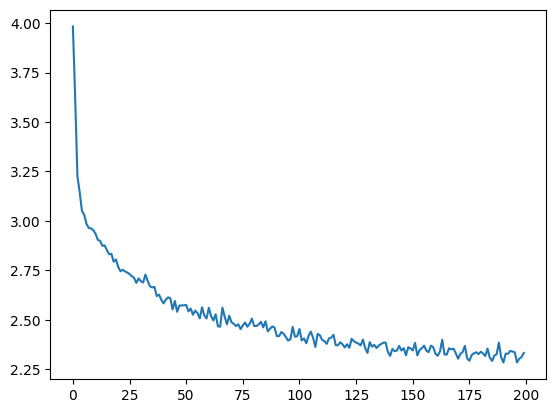

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Ramanak
Uakinov
Sakovakov
Garten
Erang
Romer
Salla
Pare
Allan
Cha
Han
Iun
